In [1]:
# using the "mellon" virtual environment
# https://mellon.readthedocs.io/en/latest/notebooks/basic_tutorial.html

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import k_means
import palantir
import mellon
import scanpy as sc

import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

In [2]:
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = [4, 4]
matplotlib.rcParams["figure.dpi"] = 125
matplotlib.rcParams["image.cmap"] = "Spectral_r"
# no bounding boxes or axis:
matplotlib.rcParams["axes.spines.bottom"] = "on"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "on"
matplotlib.rcParams["axes.spines.right"] = "off"

In [3]:
ad_url = "https://fh-pi-setty-m-eco-public.s3.amazonaws.com/mellon-tutorial/preprocessed_t-cell-depleted-bm-rna.h5ad"
ad = sc.read("data/preprocessed_t-cell-depleted-bm-rna.h5ad", backup_url=ad_url)
ad

100%|██████████| 2.33G/2.33G [01:09<00:00, 35.8MB/s]


AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

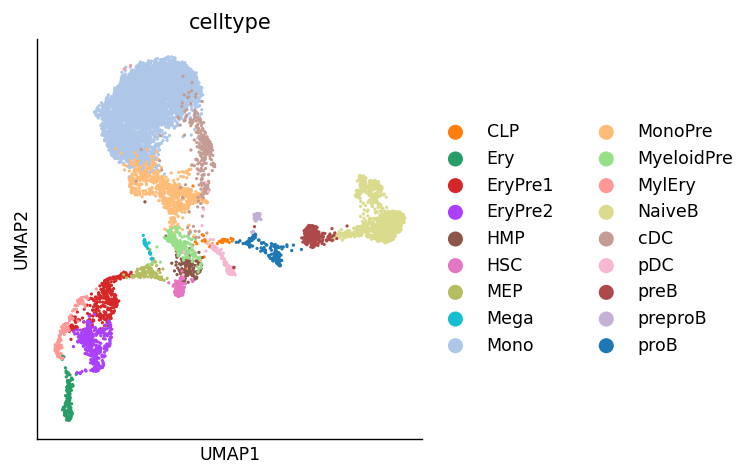

In [4]:
sc.pl.scatter(ad, basis="umap", color="celltype")

In [5]:
%%time
dm_res = palantir.utils.run_diffusion_maps(ad, pca_key="X_pca", n_components=20)

/home/users/kzlin/miniconda3/envs/mellon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 51.5 s, sys: 1.28 s, total: 52.8 s
Wall time: 49.5 s


In [6]:
%time
model = mellon.DensityEstimator()
log_density = model.fit_predict(ad.obsm["DM_EigenVectors"])

predictor = model.predict

ad.obs["mellon_log_density"] = log_density
ad.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 24.8 µs
[2024-03-31 22:03:27,095] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (8,627) and rank = 1.0.
[2024-03-31 22:03:27,097] [INFO    ] Computing nearest neighbor distances.
[2024-03-31 22:03:28,588] [INFO    ] Using embedding dimensionality d=20. Use d_method="fractal" to enable effective density normalization.
[2024-03-31 22:03:28,969] [INFO    ] Using covariance function Matern52(ls=0.008486607356042725).
[2024-03-31 22:03:28,972] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-03-31 22:03:42,928] [INFO    ] Using rank 5,000 covariance representation.
[2024-03-31 22:03:45,327] [INFO    ] Running inference using L-BFGS-B.
[2024-03-31 22:04:01,125] [INFO    ] Computing predictive function.


In [7]:
# The anndata object is updated with `obs['log_density`]` and `obs['log_density_clipped']
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

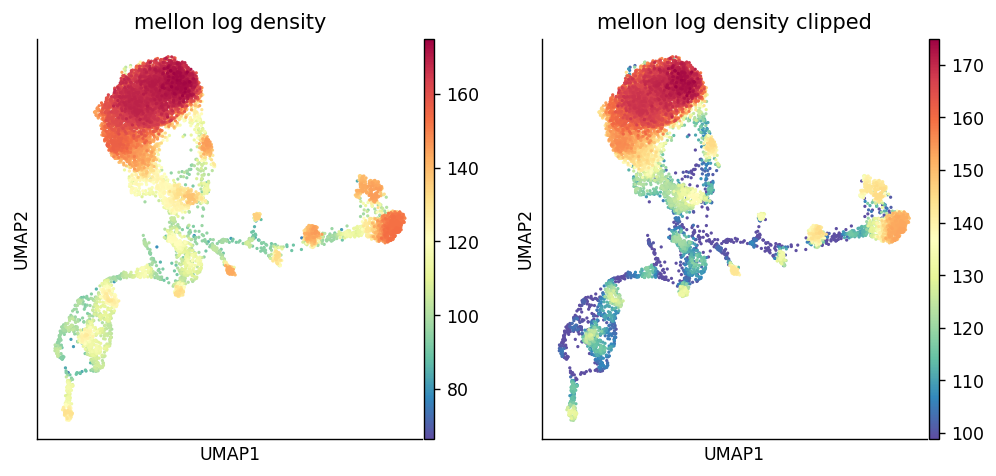

In [8]:
sc.pl.scatter(
    ad, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)

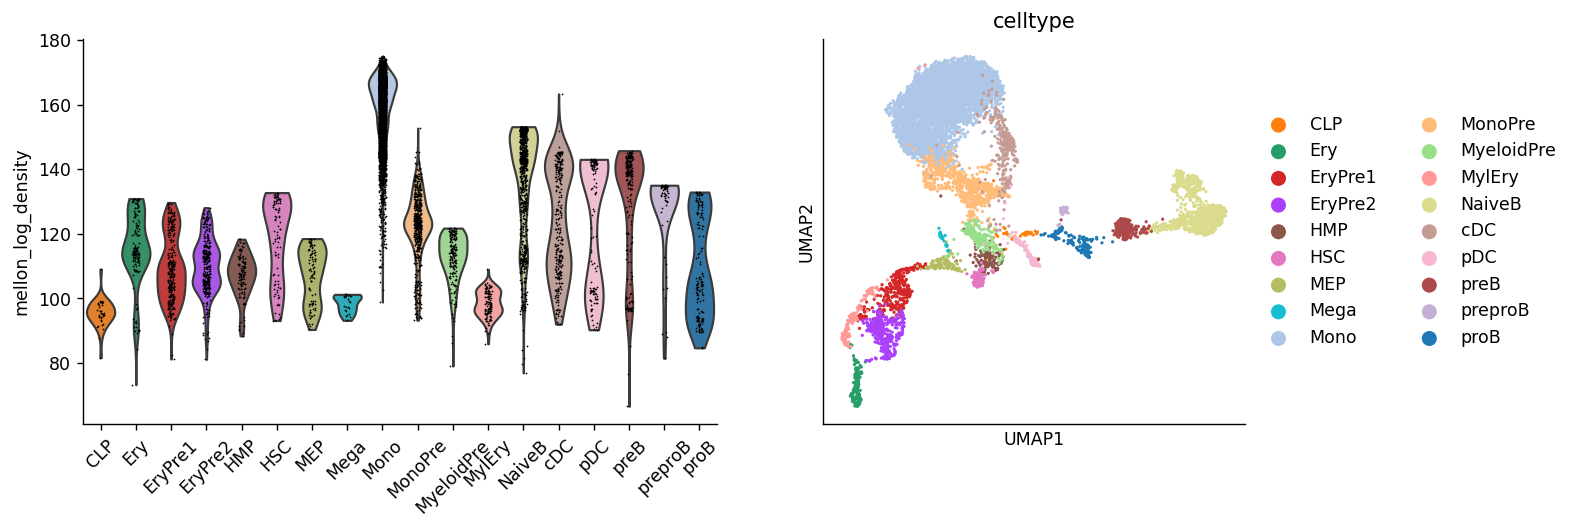

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
sc.pl.violin(ad, "mellon_log_density", "celltype", rotation=45, ax=ax1, show=False)
sc.pl.scatter(ad, color="celltype", basis="umap", ax=ax2, show=False)
plt.show()

In [10]:
ad.obs["palantir_pseudotime"], ad.obsm["palantir_lineage_cells"]

(IM-1393_BoneMarrow_TcellDep_1_multiome#GTGAGCGAGTCTCACC-1    0.138621
 IM-1393_BoneMarrow_TcellDep_1_multiome#GAGTCAAAGTCCTTCA-1    0.336803
 IM-1393_BoneMarrow_TcellDep_1_multiome#TGTGCGCAGTCGCTAG-1    0.684445
 IM-1393_BoneMarrow_TcellDep_1_multiome#ATATGTCCAATGCCTA-1    0.311772
 IM-1393_BoneMarrow_TcellDep_1_multiome#CTTAGTTTCGCTAGTG-1    0.704443
                                                                ...   
 IM-1393_BoneMarrow_TcellDep_2_multiome#ATCCGTGAGGGATTAG-1    0.309793
 IM-1393_BoneMarrow_TcellDep_2_multiome#ATTTAGGTCAGGTTTA-1    0.306938
 IM-1393_BoneMarrow_TcellDep_2_multiome#GATGGACAGATAAAGC-1    0.311873
 IM-1393_BoneMarrow_TcellDep_2_multiome#GAAGGCTAGCTATATG-1    0.312016
 IM-1393_BoneMarrow_TcellDep_2_multiome#AGACAATAGGCTCATG-1    0.311489
 Name: palantir_pseudotime, Length: 8627, dtype: float64,
                                                     NaiveB    Ery    pDC  \
 IM-1393_BoneMarrow_TcellDep_1_multiome#GTGAGCGA...   False  False  False   
 IM-139

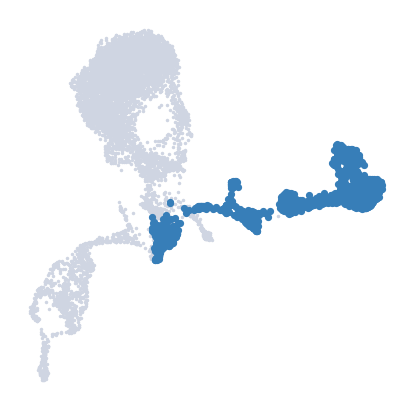

In [11]:
bcell_lineage_cells = ad.obs_names[ad.obsm["palantir_lineage_cells"]["NaiveB"]]

palantir.plot.highlight_cells_on_umap(ad, bcell_lineage_cells)
plt.show()

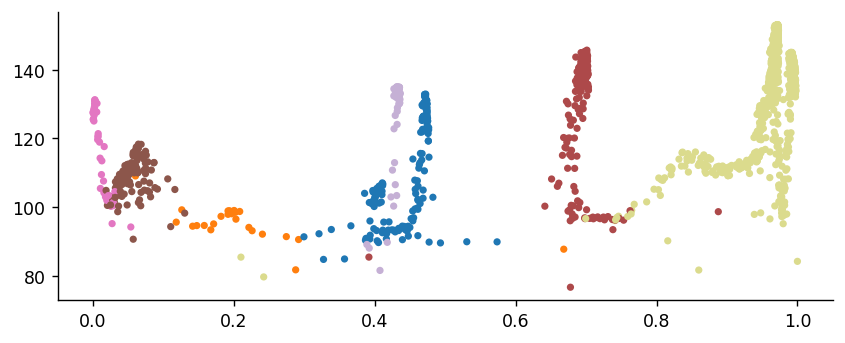

In [12]:
import pandas as pd

ct_colors = pd.Series(
    ad.uns["celltype_colors"], index=ad.obs["celltype"].values.categories
)

plt.figure(figsize=[8, 3])
plt.scatter(
    ad.obs["palantir_pseudotime"][bcell_lineage_cells],
    ad.obs["mellon_log_density"][bcell_lineage_cells],
    s=10,
    color=ct_colors[ad.obs["celltype"][bcell_lineage_cells]],
)
plt.show()

In [15]:
# Local variability of genes
palantir.utils.run_local_variability(ad)

# This will add `local_variability` as a layer to anndata
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data', 'local_variability'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivitie

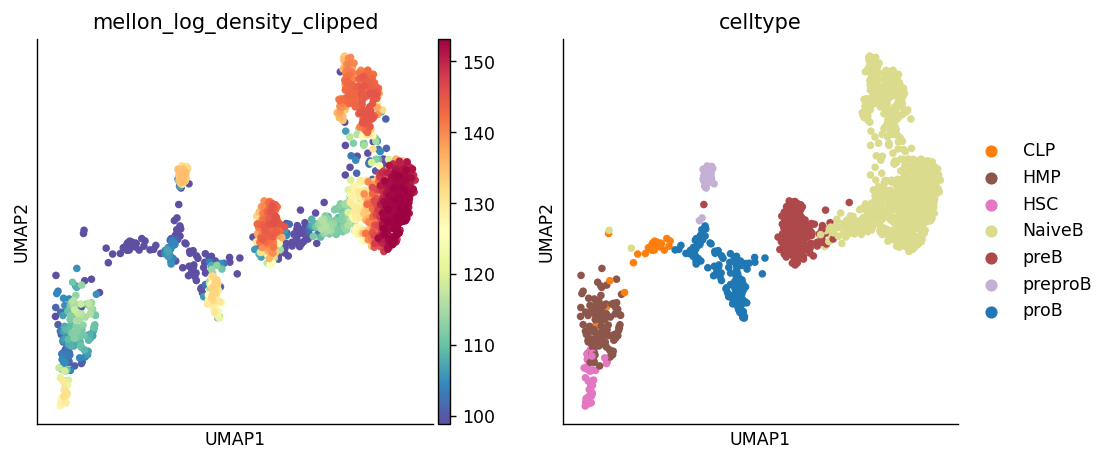

In [17]:
# UMAPs can be plotted with subsets of cells to explore densiies
sc.pl.embedding(
    ad[bcell_lineage_cells],
    basis="umap",
    color=["mellon_log_density_clipped", "celltype"],
)

In [18]:
X = ad.obsm["DM_EigenVectors"]
nn_distances = mellon.parameters.compute_nn_distances(X)

In [20]:
length_scale = mellon.parameters.compute_ls(nn_distances)
length_scale

0.008486607356042725

In [21]:
%%time
n_landmarks = 5000
landmarks = k_means(X, n_landmarks, n_init=1)[0]

CPU times: user 28.5 s, sys: 10.3 s, total: 38.7 s
Wall time: 9.47 s


In [32]:
%%time
rank = 0.999
cov_func = mellon.cov.Matern52(10*length_scale)
L = mellon.parameters.compute_L(X, cov_func, landmarks=landmarks, rank=rank)

[2024-03-31 22:13:11,708] [INFO    ] Using sparse Gaussian Process with improved Nyström rank reduction since n_landmarks (5,000) >= n_samples (8,627) and rank = 0.999.
[2024-03-31 22:13:29,699] [WARNING ] Singuarity detected in covariance matrix. This can complicated prediction. Consider raising the jitter.
[2024-03-31 22:13:41,534] [WARNING ] Singuarity detected in covariance matrix. This can complicated prediction. Consider raising the jitter.
[2024-03-31 22:13:42,095] [INFO    ] Recovering 99.900094% variance in eigendecomposition.
CPU times: user 5min 43s, sys: 2min 20s, total: 8min 4s
Wall time: 30.8 s


In [24]:
d = X.shape[1]
d

20

In [26]:
mu = mellon.parameters.compute_mu(nn_distances, d)
mu

88.00510495001697

In [33]:
%%time
initial_parameters = mellon.parameters.compute_initial_value(nn_distances, d, mu, L)

model = mellon.DensityEstimator(
    nn_distances=nn_distances,
    d=d,
    mu=mu,
    cov_func=cov_func,
    L=L,
    initial_value=initial_parameters,
)

log_density = model.fit_predict(X)

[2024-03-31 22:13:50,554] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (8,627) and rank = 1.0.
[2024-03-31 22:13:50,577] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-03-31 22:13:57,743] [INFO    ] Running inference using L-BFGS-B.
CPU times: user 1min 9s, sys: 49.7 s, total: 1min 59s
Wall time: 10.5 s


In [29]:
log_density

Array([105.43130383, 124.07539387, 114.56628955, ..., 165.95571954,
       168.08284564, 168.59741124], dtype=float64)

In [34]:
ad.obs["mellon_log_density"] = log_density
ad.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

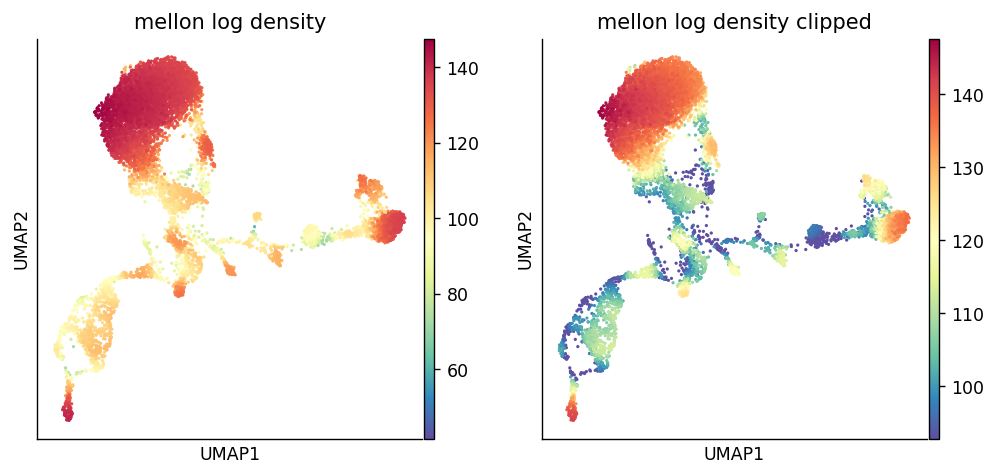

In [35]:
sc.pl.scatter(
    ad, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)